# Import packages and data 

In [1]:
# Import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc 
import scrublet as scr
from statsmodels import robust
import sys
import os.path

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==0.23.0 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=300)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load in the FBM 10X data

In [4]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad")
adata.shape

(103228, 33712)

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8763
CD56 bright NK               449
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1357
GMP                         1281
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [6]:
adata = adata[adata.obs["cell.labels"].isin(["tip EC", "sinusoidal EC"])]

In [7]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
sinusoidal EC    550
tip EC           362
dtype: int64

In [8]:
adata.shape

(912, 33712)

# Pre-process counts

In [9]:
# normalise count data 
sc.pp.normalize_total(adata)

In [10]:
# log the count data 
sc.pp.log1p(adata)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [11]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [12]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Calculate differentially expressed genes

In [13]:
# run degs on adata.X (normalised and logged data - not scaled because of issues with negative GEX values)
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
sc.tl.rank_genes_groups(adata, groupby='cell.labels', method='wilcoxon', use_raw=False, log_transformed=True)

In [14]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change = 0.25, use_raw=False)

In [15]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/figs/clustering_degs/fbm_endo_degs_20210426.csv")
degs_by_cluster[:10]

,sinusoidal EC_n,sinusoidal EC_l,tip EC_n,tip EC_l
0,CTSL,6.177714,CD34,3.885481
1,SEPP1,3.696821,VIM,3.161581
2,MS4A6A,4.758593,COL15A1,5.505641
3,STAB2,4.525580,COL4A1,3.493878
4,BST2,3.019171,PODXL,4.551607
5,PTX3,2.805862,CRIP2,2.876754
6,DAB2,3.036458,COL4A2,2.949672
7,CCL14,2.918803,ITGA6,3.497857
8,CTSD,3.426499,GSN,3.462398
9,PLAT,2.509674,ITGA2,3.595908


In [16]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/figs/clustering_degs/fbm_endo_degs_filtered_20210426.csv")
degs_by_cluster_filtered[:10]

,sinusoidal EC_names,sinusoidal EC_logfold,sinusoidal EC_pvals,sinusoidal EC_pvals_a,tip EC_names,tip EC_logfold,tip EC_pvals,tip EC_pvals_a
0,CTSL,6.177714,2.925029e-80,9.860856e-76,CD34,3.885481,9.789536e-74,8.250621e-70
1,SEPP1,3.696821,8.188693e-77,1.380286e-72,VIM,3.161581,5.299801e-71,3.573338e-67
2,MS4A6A,4.758593,5.618854e-74,6.314093e-70,COL15A1,5.505641,2.108959e-66,1.015675e-62
3,STAB2,4.525580,1.597816e-68,8.977598e-65,COL4A1,3.493878,1.176581e-65,4.958114e-62
4,BST2,3.019171,3.562366e-64,1.334383e-60,PODXL,4.551607,4.739423e-64,1.597754e-60
5,PTX3,2.805862,1.354865e-58,4.152292e-55,CRIP2,2.876754,1.083793e-53,2.435789e-50
6,DAB2,3.036458,9.281349e-58,2.607440e-54,COL4A2,2.949672,2.309066e-52,4.579013e-49
7,CCL14,2.918803,3.967277e-56,1.028807e-52,ITGA6,3.497857,4.169536e-51,7.398074e-48
8,CTSD,3.426499,3.658087e-55,8.808673e-52,GSN,3.462398,9.531216e-50,1.606582e-46
9,PLAT,2.509674,2.762024e-53,5.819584e-50,ITGA2,3.595908,8.556051e-46,1.311098e-42


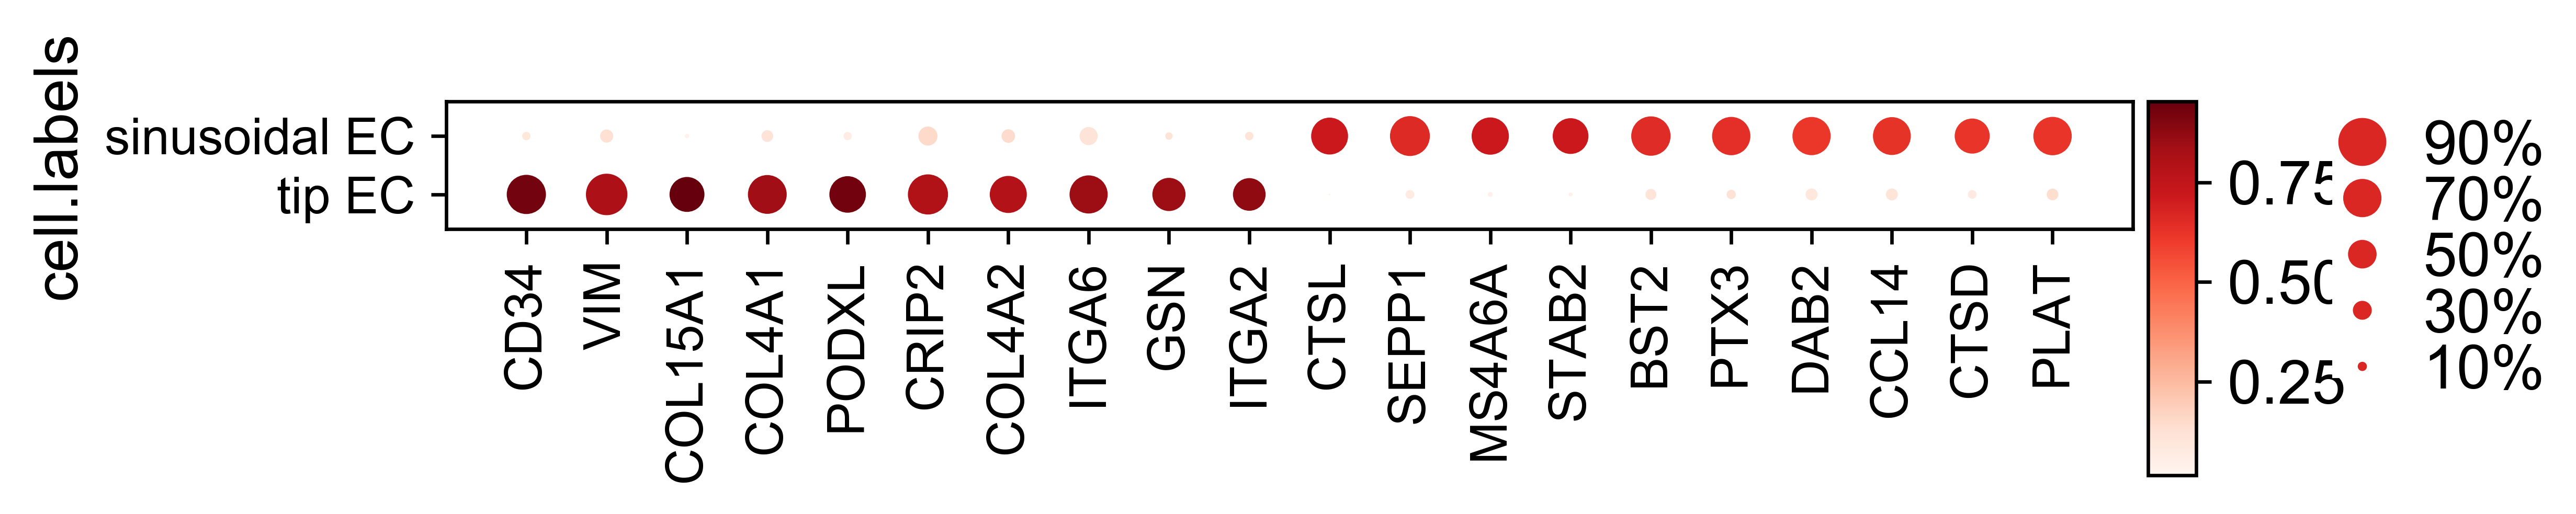

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[7.0, 0, 0.2, 0.5, 0.25])

In [17]:
sc.pl.dotplot(adata, groupby="cell.labels", use_raw=False, var_names=['CD34',
'VIM',
'COL15A1',
'COL4A1',
'PODXL',
'CRIP2',
'COL4A2',
'ITGA6',
'GSN',
'ITGA2',
'CTSL',
'SEPP1',
'MS4A6A',
'STAB2',
'BST2',
'PTX3',
'DAB2',
'CCL14',
'CTSD',
'PLAT'], save="fig6b_fbm_10x_endo_dotplot.pdf")

# Save the pre-processed data 

In [18]:
adata.shape

(912, 33712)

In [19]:
from scipy.sparse import csr_matrix
from scipy import sparse
adata.X = sparse.csr_matrix(adata.X)

In [20]:
adata.X

<912x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 2257166 stored elements in Compressed Sparse Row format>

In [21]:
adata.raw.X

<912x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 2502313 stored elements in Compressed Sparse Row format>

In [22]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/data/fig6b_fbm_10_endo_degs_20210426.h5ad")